In [191]:
import classification_utils
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm._libsvm import cross_validation
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression


In [192]:
TARGET_NAMES = ['No Playoffs', 'Playoffs']
N_FOLDS_CV = 9
PREDICTION_YEAR = 9

df = pd.read_csv('../newData/Shifted_playoff.csv')

# Split data into train years and test year (year 10)
teams_train_df = df[df['year'] < PREDICTION_YEAR]
teams_test_df = df[df['year'] == PREDICTION_YEAR]

cross_val_scores = []

In [193]:
y_train = teams_train_df['playoff']
y_test = teams_test_df['playoff']
X_train = teams_train_df.drop(['playoff', 'year', 'tmID'], axis=1)
X_test = teams_test_df.drop(['playoff', 'year', 'tmID'], axis=1)

# Normalize the data as KNN, Neural Networks, SVM, ... expect the data to be normalized
X_train_normalized, X_test_normalized = classification_utils.normalize_df(X_train, X_test)

X_normalized = pd.concat([X_train_normalized, X_test_normalized])
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


## Random Forest

Accuracy: 1.0
[[5 0]
 [0 8]]


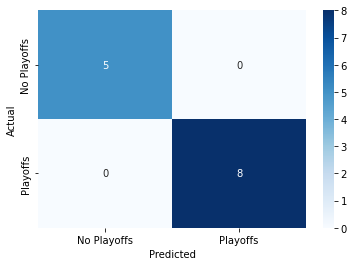

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

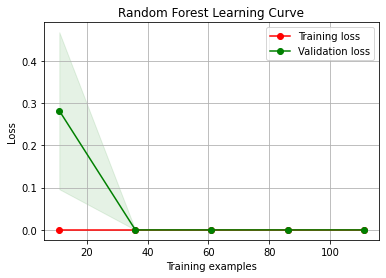

In [194]:
clf = RandomForestClassifier()

y_pred = classification_utils.print_results(clf, X_train, X_test, y_train, y_test)

classification_utils.plot_learning_curve(clf, 'Random Forest Learning Curve', X, y)

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[5 0]
 [0 8]]


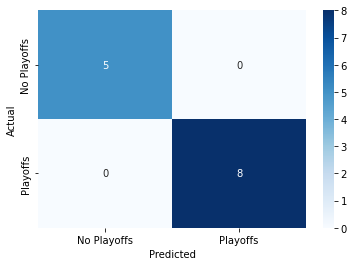

Cross-Validation Results:
Mean Accuracy: 100.00%
Standard Deviation: 0.00


In [195]:
classification_utils.force_qualify_8_teams(clf, X_test, y_test)
scores = classification_utils.cross_validation(clf, X, y)
cross_val_scores.append(scores)

## KNN

Accuracy: 0.9230769230769231
[[4 1]
 [0 8]]


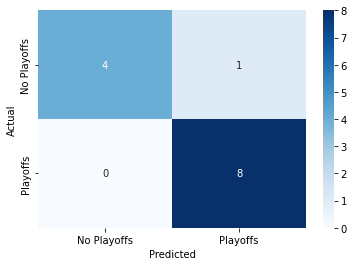

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.8461538461538461
[[4 1]
 [1 7]]


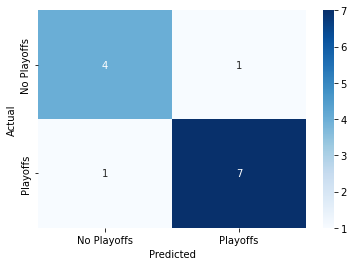

Cross-validation scores: [0.8        0.88       0.76       0.84       0.79166667]
Mean CV score: 0.8143333333333335


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

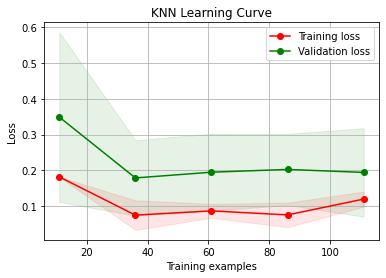

In [196]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Addestramento e predizione
y_pred = classification_utils.print_results(knn_classifier, X_train_normalized, X_test_normalized, y_train, y_test)
y_pred = classification_utils.force_qualify_8_teams(knn_classifier, X_test_normalized, y_test)

# Cross-validation
scores = cross_val_score(knn_classifier, X_normalized, y, cv=5)
cross_val_scores.append(scores)

print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())

# Plot della curva di apprendimento
classification_utils.plot_learning_curve(knn_classifier, 'KNN Learning Curve', X_normalized, y)


<ipython-input-197-fbc0be855755>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN'])


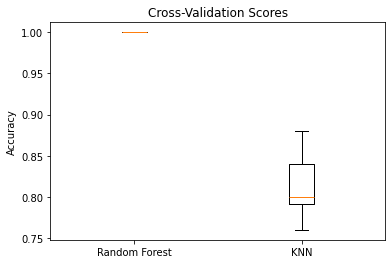

In [197]:
plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN'])
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.show()

## Rolling Window

In [198]:
ROLLING_WIN_SIZE = 3  # You can adjust this value

In [199]:
def create_rolling_window_dataset(df, rolling_win_size):
    '''This function creates a list of dataframes, where each 
    dataframe contains the data from the previous n years.
    It creates an entry for each year that the team has played.'''

    df_rolling = []
    for year in range(2, PREDICTION_YEAR + 1):
        df_year = df[df['year'] == year]
        df_prev_years = df[(df['year'] < year) & (df['year'] >= year - rolling_win_size)]

        # Take the data into a df for each team
        for team in df_year['tmID'].unique():
            # Take the data from the previous years for the same team
            df_team_prev_years = df_prev_years[df_prev_years['tmID'] == team]

            # Add the dataframe to the list
            df_rolling.append(df_team_prev_years)

    return df_rolling

def generate_weights(window_size):
    weights = np.linspace(0.1, 1, window_size)
    weights /= weights.sum()  # Normalize weights to ensure they sum to 1
    return weights

def rolling_window_df():
    # Create the rolling window datasets
    rolling_window_historic = create_rolling_window_dataset(df,  ROLLING_WIN_SIZE)

    weighted_features = df.drop(['year', 'tmID', 'playoff'], axis=1).select_dtypes(include=np.number).columns.tolist()
    
    # Create a new dataframe to store the rolling window data
    rolling_data = pd.DataFrame(columns=df.columns)

    for window in rolling_window_historic:

        #Create a new empty line for the rolling_data dataframe
        rolling_data_line = pd.DataFrame(columns=df.columns)

        if len(window) != 0:
            #1. Get the weights for the weighted average
            weights = generate_weights(len(window))

            #2. Get the weighted average of the weighted features
            #Note: The weighted average is calculated as follows:
            #weighted average = sum of (weight * feature value) / sum of weights
            #For example, if the weights are [0.2, 0.3, 0.5] and the feature values are [10, 20, 30], then the weighted average is:
            #weighted average = (0.2 * 10 + 0.3 * 20 + 0.5 * 30) / (0.2 + 0.3 + 0.5) = 24
            for feature in weighted_features:
                weighted_average = np.average(window[feature].values, weights=weights)
                rolling_data_line[feature] = [weighted_average]

            #3. Join that data with the data from the following year (the year we want to predict)
            #Note: The data from the following year will be used as the target label, get next year from the teams_df dataframe
            next_year = window['year'].max() + 1
            next_year_data = df[(df['tmID'] == window['tmID'].values[0]) & (df['year'] == next_year)]

        #Add year, confID, tmID, and playoff columns
        try:
            rolling_data_line['year'] = next_year
            rolling_data_line['tmID'] = window['tmID'].values[0]
            rolling_data_line['playoff'] = next_year_data['playoff'].values[0]
        except:
            #If there is no data for the next year, skip this line
            #print('No data for next year')
            continue
        
        #4. Concat the data to the rolling_data dataframe
        rolling_data = pd.concat([rolling_data, rolling_data_line])

    rolling_data = rolling_data.reset_index(drop=True)

    return rolling_data

In [200]:
rolling_data = rolling_window_df()
rolling_data.head()

<ipython-input-199-c49f653fe1c9>:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rolling_data = pd.concat([rolling_data, rolling_data_line])


,year,tmID,confID,rank,playoff,o_fga,o_fta,o_3pa,o_oreb,o_dreb,...,d_asts,height,weight,winrate,TPI_Sum,roundsPlayed,award_player,award_coach,playersAge,PlayOffNextYear
0,2,CHA,0.0,1.000000,1,0.374866,0.261501,0.303183,0.460870,0.276284,...,0.702703,0.356688,0.542825,0.174757,0.201766,0.000000,0.000000,0.0,0.425218,1.0
1,2,CLE,0.0,0.142857,1,0.294307,0.244552,0.338358,0.573913,0.210269,...,0.513514,0.059448,0.282536,0.546117,0.309934,0.666667,0.000000,0.0,0.465186,1.0
2,2,CON,0.0,0.285714,0,0.383459,0.186441,0.366834,0.521739,0.217604,...,0.500000,0.148620,0.452725,0.504854,0.343046,0.333333,0.000000,0.0,0.505155,0.0
3,2,DET,0.0,0.571429,0,0.457573,0.556901,0.113903,0.617391,0.310513,...,0.422297,0.267516,0.285873,0.422330,0.328477,0.000000,0.000000,0.0,0.265345,0.0
4,2,HOU,1.0,0.142857,1,0.365199,0.399516,0.479062,0.321739,0.506112,...,0.287162,0.505308,0.426029,0.958738,0.611038,1.000000,0.666667,0.0,0.931483,1.0


## Random Forest with Rolling Window

In [201]:
y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_train_normalized, X_test_normalized = classification_utils.normalize_df(X_train, X_test)

X = pd.concat([X_train, X_test])
X_normalized = pd.concat([X_train_normalized, X_test_normalized])
y = pd.concat([y_train, y_test])

Accuracy: 1.0
[[4 0]
 [0 8]]


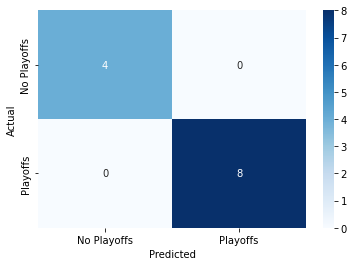

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


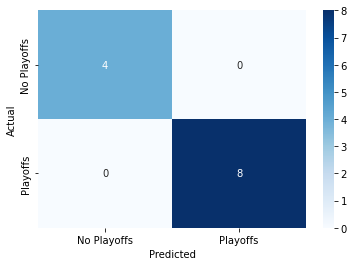

Cross-Validation Results:
Mean Accuracy: 99.07%
Standard Deviation: 0.03


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

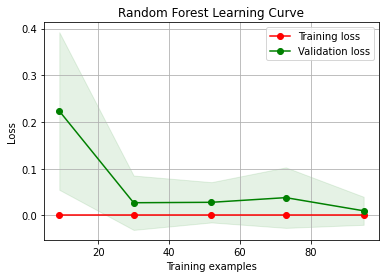

In [202]:
clf = RandomForestClassifier(n_estimators=100)

y_pred = classification_utils.print_results(clf, X_train, X_test, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test, y_test)

scores = classification_utils.cross_validation(clf, X, y, 9)

classification_utils.plot_learning_curve(clf, 'Random Forest Learning Curve', X, y)

## Grid Search

### Random Forest

In [203]:
# Use grid search to find the best parameters
cross_val_scores = []
best_clf = {}
grid_search_params = {}
grid_search_models = {}

parameters = {
    'n_estimators': [5, 10],
    'max_depth': [3, 5], 
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10] 
}

clf = RandomForestClassifier()
grid_search_models['Random Forest'] = clf
grid_search_params['Random Forest'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['Random Forest'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.9888888888888889
RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=10)


/opt/homebrew/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy: 1.0
[[4 0]
 [0 8]]


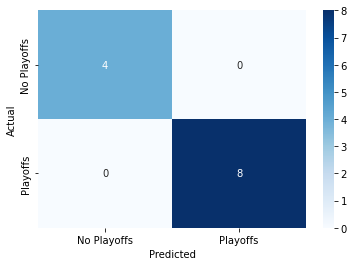

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


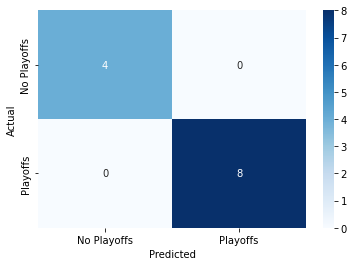

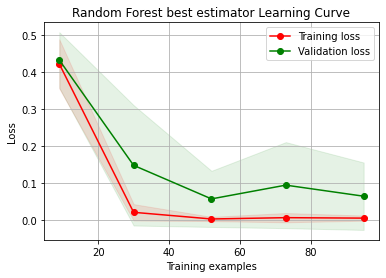

In [204]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train, X_test, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test, y_test)
scores = grid_search.cv_results_['mean_test_score']
classification_utils.plot_learning_curve(clf, 'Random Forest best estimator Learning Curve', X, y)
cross_val_scores.append(scores)

### KNN

In [205]:
# Use grid search to find the best parameters
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
clf = KNeighborsClassifier()
grid_search_models['KNN'] = clf
grid_search_params['KNN'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['KNN'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_neighbors': 9, 'weights': 'uniform'}
0.7222222222222223
KNeighborsClassifier(n_neighbors=9)


Accuracy: 0.6666666666666666
[[1 3]
 [1 7]]


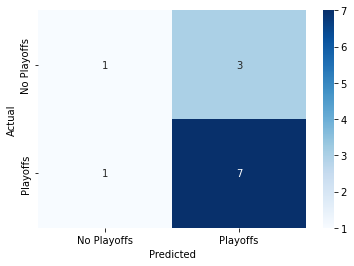

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.8333333333333334
[[3 1]
 [1 7]]


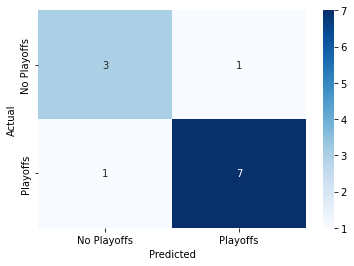

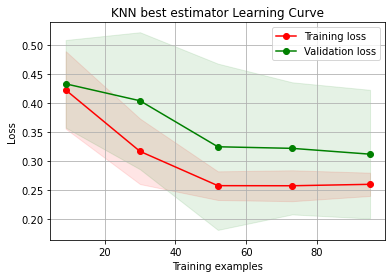

In [206]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = grid_search.cv_results_['mean_test_score']
classification_utils.plot_learning_curve(clf, 'KNN best estimator Learning Curve', X_normalized, y)
cross_val_scores.append(scores)

### Gradient Boosting

In [207]:
parameters = {
    "learning_rate": [0.01, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,8],
    "max_features":["log2",None],
    "subsample":[0.8, 1.0],
    "n_estimators":[100]
}
clf = GradientBoostingClassifier()
grid_search_models['Gradient Boosting'] = clf
grid_search_params['Gradient Boosting'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['Gradient Boosting'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': np.float64(0.1), 'min_samples_split': np.float64(0.1), 'n_estimators': 100, 'subsample': 0.8}
1.0
GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=np.float64(0.1),
                           min_samples_split=np.float64(0.1), subsample=0.8)


Accuracy: 1.0
[[4 0]
 [0 8]]


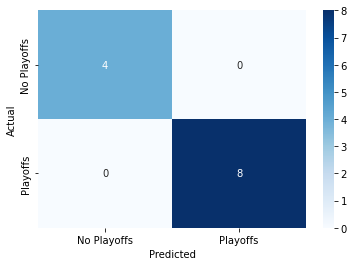

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


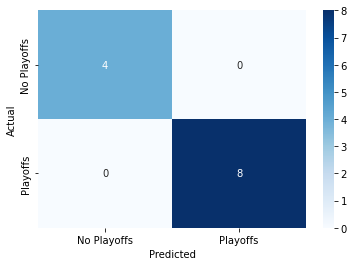

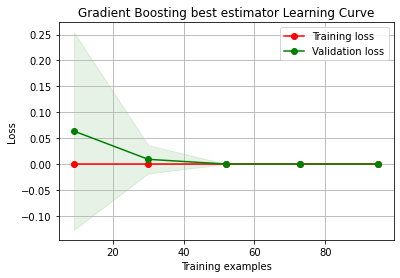

In [208]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train, X_test, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test, y_test)
scores = grid_search.cv_results_['mean_test_score']
classification_utils.plot_learning_curve(clf, 'Gradient Boosting best estimator Learning Curve', X, y)
cross_val_scores.append(scores)

### XBoost

In [209]:
X_train['confID'] = X_train['confID'].astype('bool')
X_test['confID'] = X_test['confID'].astype('bool')
X = pd.concat([X_train, X_test])

parameters = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 1.0],
    'n_estimators': [100, 200]
}
clf = xgb.XGBClassifier()
grid_search_models['XGBoost'] = clf
grid_search_params['XGBoost'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['XGBoost'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
1.0
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Accuracy: 1.0
[[4 0]
 [0 8]]


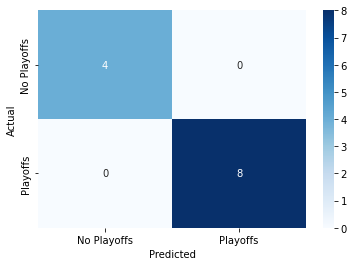

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


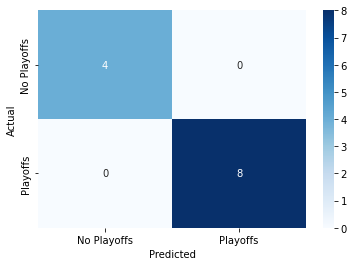

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

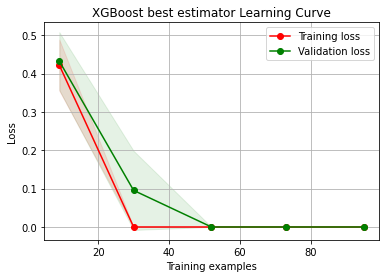

In [210]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train, X_test, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test, y_test)
scores = grid_search.cv_results_['mean_test_score']
cross_val_scores.append(scores)
classification_utils.plot_learning_curve(clf, 'XGBoost best estimator Learning Curve', X, y)

### SVM

In [211]:
parameters = {
    'C': [0.01, 0.1, 1], 
    'gamma': ['scale'], 
    'kernel': ['linear'],
    'class_weight': ['balanced'],
    'probability': [True]
}
clf = svm.SVC()
grid_search_models['SVM'] = clf
grid_search_params['SVM'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['SVM'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
0.9555555555555555
SVC(C=1, class_weight='balanced', kernel='linear', probability=True)


Accuracy: 1.0
[[4 0]
 [0 8]]


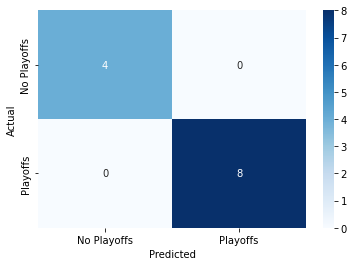

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


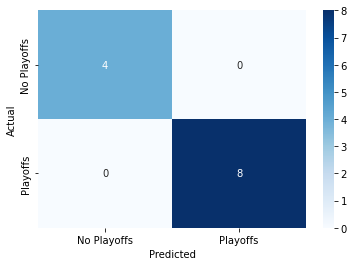

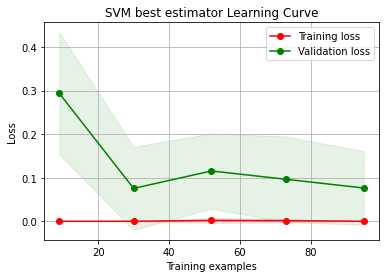

In [212]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = grid_search.cv_results_['mean_test_score']
classification_utils.plot_learning_curve(clf, 'SVM best estimator Learning Curve', X_normalized, y)
cross_val_scores.append(scores)

### Logistic Regression

In [213]:
parameters = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced'],
    'solver': ['liblinear'],
    'max_iter': [100],
}

clf = LogisticRegression()
grid_search_models['LogisticRegression'] = clf
grid_search_params['LogisticRegression'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Estimator:", grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['LogisticRegression'] = (grid_search.best_score_, clf)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 1.0
Best Estimator: LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                   solver='liblinear')


Accuracy: 1.0
[[4 0]
 [0 8]]


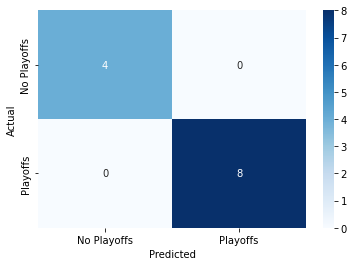

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[4 0]
 [0 8]]


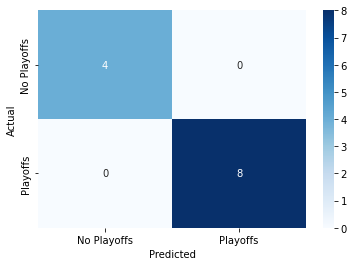

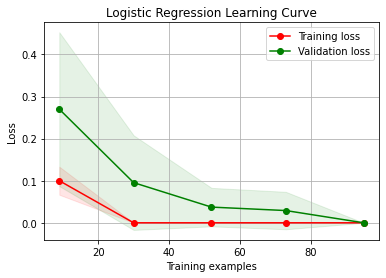

In [214]:
# Use the best parameters to train the model
y_pred = classification_utils.print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
classification_utils.force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = grid_search.cv_results_['mean_test_score']
classification_utils.plot_learning_curve(clf, 'Logistic Regression Learning Curve', X_normalized, y)
cross_val_scores.append(scores)

## Plotting the Results

<ipython-input-215-9739d19dbbfe>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cross_val_scores, labels=best_clf.keys())


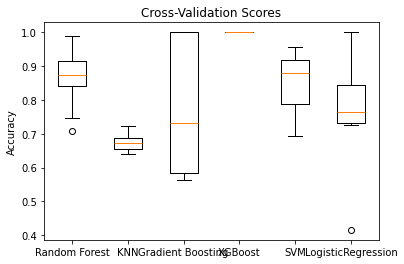

In [215]:
#plot the cross validation scores
plt.boxplot(cross_val_scores, labels=best_clf.keys())
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy') 
plt.show()

The best classifier is Gradient Boosting with a score of 1.0


<ipython-input-199-c49f653fe1c9>:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rolling_data = pd.concat([rolling_data, rolling_data_line])


TypeError: cross_validation() got an unexpected keyword argument 'output'

In [216]:
# TODO list per la avalicao
# commentare correttamente tutto il codice
# provare a considerare in maniera diversa i premi di ogni player all'interno del team - per influenzare eventuali future vittorie
# provare più metodi di classification !!!
# aggiustare win rate
# iniziare bozza presentazione
# scegliere main topics presentazione
# mettere nella presentazione la cosa delle scommesse
# mettere in ordine i folders a sinistra
# shift della colonna dei playoff - vedi foto
# eseguzione pipeline - run file per lanciare tutto
# tante belle cose